# Truncated mass distribution collapse simulation


In this notebook we're going to simulate the collapse of a truncated sphere mass distribution. We're going to infer how the masses collapse in the $T_{dyn}$ (dynamical time) and if they somehow expand in the outer space without crushing on one another. 

## Basics on this type of system

We decided to study the case of a $\textit{Keplerian potential}$ in an homogeneous sphere that's truncated at a given radius $a$. 


![](trunc_sphere.png)


The $\rho_0$ density parameter is defined as constant inside the sphere, while it's null elsewhere. The following relationships stand: 

$$M(R)=\frac{4 \pi}{3} \rho_0 R^{3}$$

$$v(R)=\sqrt{\frac{4 \pi G}{3} \rho_0} R$$

$$T_{orbital}=\frac{2 \pi R}{v(R)} =  \sqrt{\frac{3 \pi}{G \rho_{0}}}$$


We can define the $\textbf{dynamical time}$ as the time to go from $R$ to 0, starting with $v = 0$ with respect to the distribution, and $\textit{assuming}$ a static potential $\Phi$.

Skipping the passages to get here (we all know them :) ) this is what we get: 

$$T_{dynam} = \sqrt{\frac{3 \pi}{16 G \rho_0}}$$

The system stability is tested over multple dynamical times, for instance $20 \cdot T_{dynam}$. Usually, if the system is not stable we have another quantity that's useful to know: the $\textbf{collapse time}$. Again, skipping all the passages to get here: 

$$T_{coll} = \sqrt{\frac{3 \pi}{32 G \rho_0}} = \frac{T_{dynam}}{\sqrt{2}}$$

What are the implications of a spherical distribution such as the one described above in real life? Such a system, if real, would collapse to the center due to its own gravity and produce a supermassive black hole. This does not happen due to some discrepancies with the theory: 

- 1) Are we really sure that the system is homogeneous and isotropic?
- 2) At some point the Newtonian dynamics won't work anymore; 
- 3) We only have finite $Ns$ of particles, not $\infty$, this is totally related to the above points. The particles can change their energy drastically due to transfer from system and other particles. The total energy is conserved, some particles become more bound and some are ejected even if their energy was initially negative. 

This summarizes well what we're (hopefully!) going to investigate in the following lines. 

## Analysis: 

We followed these steps: 

- We generated the N masses to work with, according to their correct distribution; 
- We produced the input file for the simulation; 
- We simulated the N-body problem; 
- We analyzed the outcoming results, checking their consistency. 

In [73]:
import numpy as np
import matplotlib

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [75]:
# set initial variables/ uninitialized arrays

N = 100
M = 1 # * N
m = M / N
a = 1

In [76]:
from scipy.stats import uniform

Generating the masses of the truncated sphere: 

In [77]:
cdf_r = uniform.rvs(0, 1, size=N)  # cumulative function of rs
rays = a * (cdf_r)**(1/3)

cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
thetas = np.arccos(1 - 2 * cdf_theta)

phis = uniform.rvs(0, 2 * np.pi, size=N) 

Converting to $\textbf{cartesian}$ coordinates: 

In [78]:
x = rays * np.sin(thetas) * np.cos(phis)
y = rays * np.sin(thetas) * np.sin(phis)
z = rays * np.cos(thetas) 

Check the generated distribution with the 3D plot: 

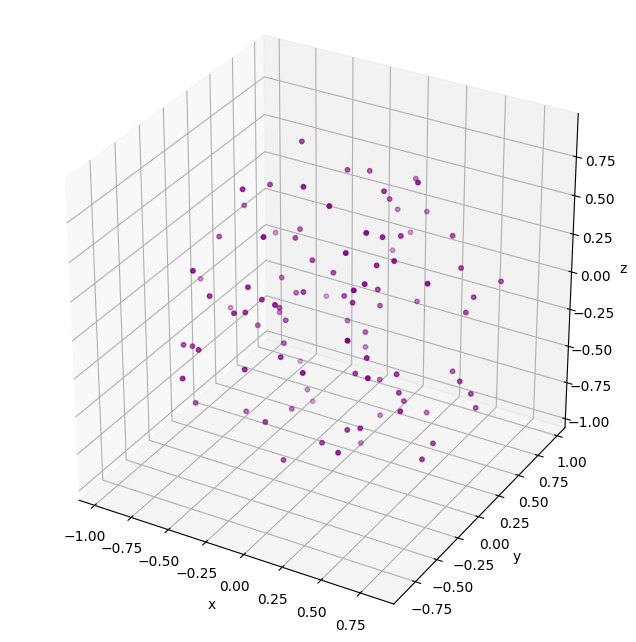

In [79]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c = 'purple', s=10.5)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

Here we decided to check the correctness of the generated coordinates: we first need to understand the shape of each $p(r)$, $p(\theta)$, $p(\psi)$ and then see if the normalized histogram of generated data actually follows these distributions. 

Briefly: 

- R case: 

$$p(r) = \frac{3 r^{2}}{a**3}$$

- $\Theta$ case: 

$$p(\Theta) = \frac{sin(\theta)}{2}$$

- $\psi$ case: 

$$p(\psi) = \frac{1}{2 \pi}$$


All of the above have been evaluated to be normalized over the interval chosen for each parameter. 

In [80]:
V_sphere = 4 * np.pi / 3 * a**3

def analytic_distr_R(N, a):
    
    rs = np.linspace(0, a, N)
    
    return rs, 3 * rs**2 / a**3  # knowing that p(r) = 3 * rs**2 / a**3

def analytic_distr_theta(N, a):
    
    thetas = np.linspace(0, np.pi, N)
    
    return thetas, np.sin(thetas) / 2

def analytic_distr_phi(N, a):
    
    phis = np.linspace(0, 2 * np.pi, N)
    
    distr = [1 / (2 * np.pi - 0)] * N  # already normalized
    
    return phis, distr

Plot the distributions: 

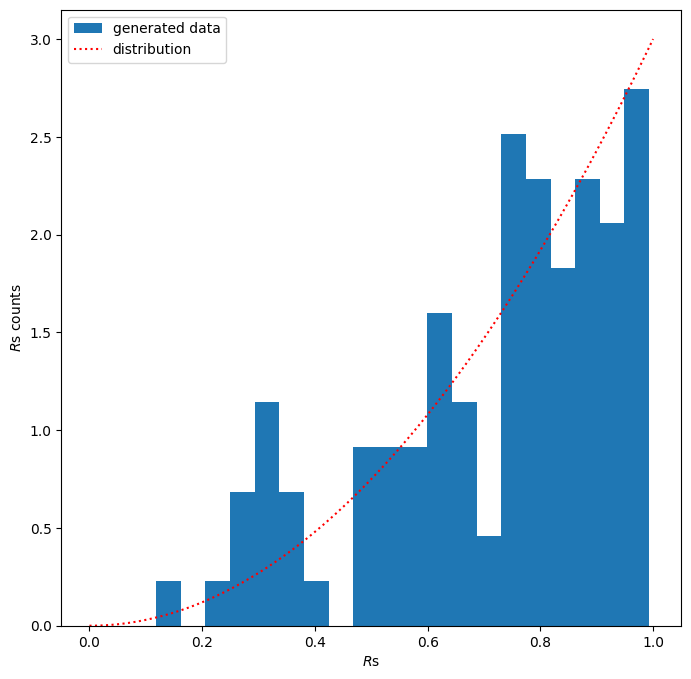

In [81]:
plt.figure(figsize = (8,8))

plt.hist(rays, 20, density=True, label="generated data")
plt.plot(analytic_distr_R(N, a)[0], analytic_distr_R(N, a)[1], c='red', ls=':', label="distribution")
plt.xlabel("$R$s")
plt.ylabel("$R$s counts")
plt.legend()
plt.show()

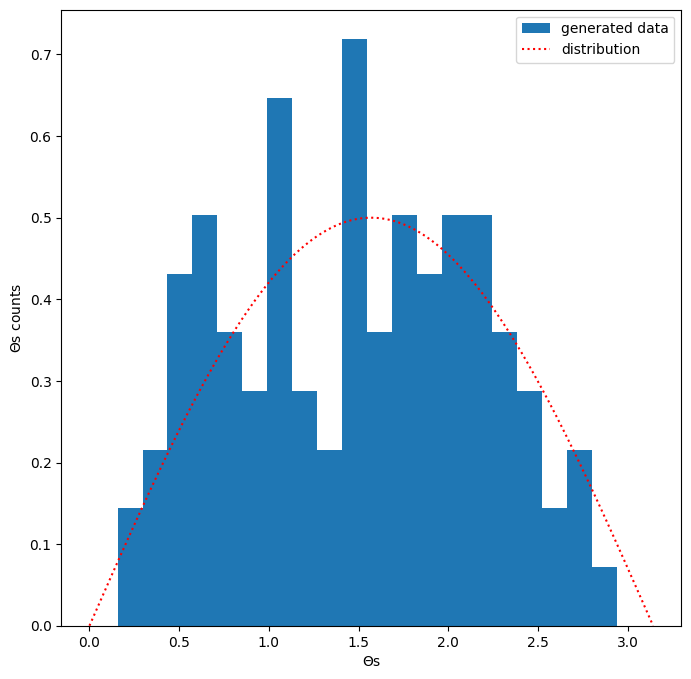

In [82]:
plt.figure(figsize = (8,8))

plt.hist(thetas, 20, density=True, label="generated data")
plt.plot(analytic_distr_theta(N, a)[0], analytic_distr_theta(N, a)[1], c='red', ls=':', label="distribution")

plt.xlabel("$\Theta$s")
plt.ylabel("$\Theta$s counts")
plt.legend()

plt.show()

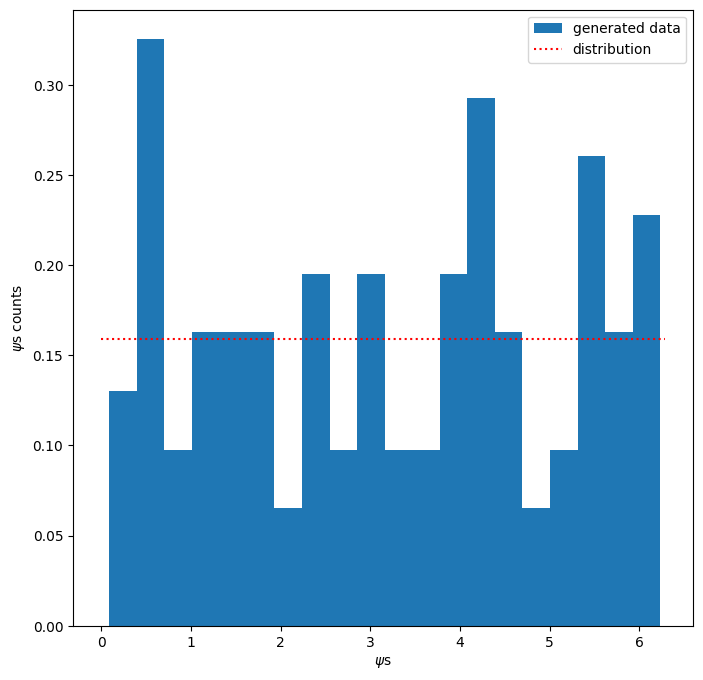

In [83]:
plt.figure(figsize = (8,8))

plt.hist(phis, 20, density=True, label="generated data")
plt.plot(analytic_distr_phi(N, a)[0], analytic_distr_phi(N, a)[1], c='red', ls=':', label="distribution")


plt.xlabel("$\psi$s")
plt.ylabel("$\psi$s counts")
plt.legend()
plt.show()

With just $100$ masses it's not entirely visible but if we change the number to $1000$ or more the distributions are correct. 

In [84]:
def DensityTest(r):
    r_test = np.random.uniform(0,a, 2)
    r1 = r_test.min()
    r2 = r_test.max()

    # Volume of the shell
    Vshell = 4*np.pi/3*(r2**3 - r1**3)

    # Check which points lie within the volume
    enclosed_points = ((r >= r1) & (r <= r2))
    # Count the number of enclosed points
    num_enclosed_points = np.sum(enclosed_points)
    density = num_enclosed_points/Vshell

    return density

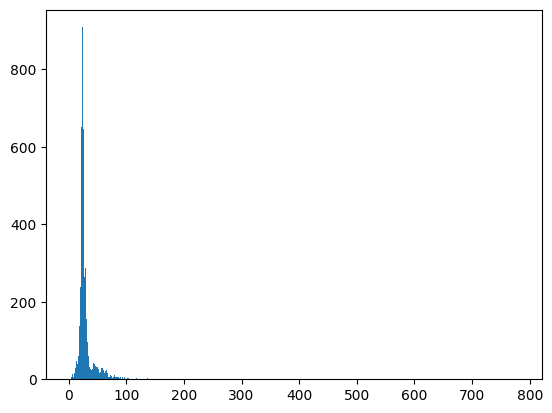

In [95]:
M = 10000
tests = []

for i in range(M):
    density = DensityTest(rays)
    tests.append(density)
    
plt.hist(tests,1000)
plt.show()

### Initial conditions file:

In [58]:
# open the file
file = open('homogeneous_sphere_initial.txt', 'w')

# write the file
file.write(f'{N}\n')
file.write('3\n') # dimensions
file.write('0\n')

for i in range(N):
    file.write(f'0.01\n')

for i in range(N):
    file.write(f'{x[i]} {y[i]} {z[i]}\n')
    
for i in range(N):
    file.write(f'{0} {0} {0}\n')

# close the file
file.close()

We set some easy functions to extract the dynamical and collapse time. 

In [59]:
def dyn_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (16 * G * rho_0)) 

def coll_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (32 * G * rho_0))

To plug something in we need to evaluate $\rho_0$: 

In [60]:
rho0 = M / V_sphere # N * 1 masses of stars

In [61]:
rho0

0.23873241463784303

Printing then both of them (it totally makes sense to do so, in order to establish the duration of the simulation):

In [62]:
print("The dynamical time is: ", dyn_time(rho0))
print("The collapse time is: ", coll_time(rho0))

The dynamical time is:  1.5707963267948963
The collapse time is:  1.1107207345395915


We find the softening parameter $\epsilon$ via


$$\epsilon = \left(\frac{V}{N}\right)^{1/3}$$

In [63]:
eps = (V_sphere / N)**(1/3)

In [64]:
print("softening:", eps)

softening: 0.34729313857853633


And the accuracy parameter $\theta$ is evaluated via 

$$\theta_{crit} = \frac{\Omega_{shell}}{d_{p, CM}}$$

As shell, we chose a volume of $\frac{V_{sphere} N_p}{N}$, where $N$ is the number of particles, $N_p$ the particles we want for each small volume and $V_{sphere}$ the total volume of the sphere. If we place the particle at a distance $\frac{a}{2}$ from the volume and we obtain: 

In [65]:
Np = 80

In [66]:
theta_c = (V_sphere / N) * Np / (a/2) 

In [67]:
print("theta accuracy:", theta_c)

theta accuracy: 6.702064327658225


In [68]:
#command to run the code
#./treecode in=homogeneous_sphere_initial.txt out=output.txt dtime=0.01 eps=0.7 theta=0.3 tstop=1.1107207345395915 dtout=0.1